In [137]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 14 19:13:50 2019

@author: roger
"""
#%%
import pandas as pd
import matplotlib.pyplot as plt
import mwinai as mw
import numpy as np
import corner
import emcee


#%%
def generate_ANN(ANN_name, X_train, Y_train, activation, layers, solver,saved = False):
    RM = mw.manage_RM(RM_filename = ANN_name)
    if (RM.N_in == 0) or (saved == False):

        RM = mw.manage_RM(RM_type = 'SK_ANN', X_train=X_train, y_train=Y_train,
                   scaling=True, clear_session=True, split_ratio = 0.3, verbose = True)
        RM.init_RM(hidden_layer_sizes = layers, max_iter = 2000, tol = 1e-7, activation = activation,
                  solver = solver)
        RM.train_RM()
        RM.predict(scoring = True)
        RM.save_RM(ANN_name, save_train = True, save_test = True)
    else:
        print('Already saved ANN, reading..')
        RM.predict(scoring = True)
        print('DONE!')
    return RM


def model(parameters):
    RM.set_test(np.array(parameters))
    RM.predict()
    model_out = RM.pred
    return model_out


def lnprob(parameters):
    X = X_train_det.shape[1]
    mask = ((parameters >= X_train_det.min(0)) & (parameters <= X_train_det.max(0))).sum(1) != X
    res = -0.5 * np.sum((model(parameters) - target)**2,1)
    res[mask] = -np.inf
    return res


def main(p0, walkers, niter, ndim, lnprob, vectorized= False):
    sampler = emcee.EnsembleSampler(walkers, ndim, lnprob, vectorize = vectorized)
    
    print("Calentamiento..")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    print("Corriendo MCMC")
    pos, porb, state = sampler.run_mcmc(p0, niter)
    print("Listo!")
    
    return sampler, pos, porb, state
#%%


In [135]:
X = X_train_det.shape[1]
mask = ((p01 >= X_train_det.min(0)) & (p01 <= X_train_det.max(0))).sum(1) != X
res = -0.5 * np.sum((model(p01) - target)**2,1)
res[mask] = -np.inf

In [124]:
p01.shape

(500, 3)

In [149]:
#Vector con las edades
    

df = pd.read_csv("all_data_good.csv")

del df["Unnamed: 0"]
df["log_age"] = np.log10(df["Age(yr)"])
df["log_met"] = np.log10(df["Metal(Zo)"])

sub = df.copy()
sub = df.loc[((df['Metal(Zo)'] == 0.013999999999999999) | (df['Metal(Zo)'] == 0.001)  ) & ((df['Mass (Mo)'] == 1e5) | (df['Mass (Mo)'] == 1e4))].copy()
sub = df.loc[(df['Mass (Mo)'] == 1e3) | (df['Mass (Mo)'] == 1e4)].copy()
sub['age_bin'] = 0
sub.loc[sub['Age(yr)'] ==1e6, 'age_bin'] = 1
sub.loc[sub['Age(yr)'] ==3.0e6, 'age_bin'] = 2
sub.loc[sub['Age(yr)'] ==3.98e6, 'age_bin'] = 3
sub.loc[sub['Age(yr)'] ==7.94e6, 'age_bin'] = 4
sub['log_mass'] = np.log10(sub['Mass (Mo)'])


Y_train_det = sub[['F275W', 'F336W', 'F438W', 'F555W', 'F814W', 'F547M', 'F657N']].to_numpy()



X_train_det = sub[['log_mass', 'log_age', 'log_met']].to_numpy()
 
    
B_V = sub.loc[:,'F336W'] - sub.loc[:, 'F438W'].to_numpy()
U_B = sub.loc[:,'F275W'] - sub.loc[:, 'F336W'].to_numpy()
V = sub.loc[:,'F438W'].to_numpy()



Y_train = np.array([B_V, U_B, V]).T    

#%%
layers = (100, 100, 100, 100)
solver = 'adam'
acvitacion = 'relu'
RM = generate_ANN('det_mass_ANN', X_train_det, Y_train,activation =activation, layers = layers, solver= solver , saved = False)



Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 50918, Test set size = 5658
Train data scaled. 
Test data scaled. 
Training set size = 50918, Test set size = 5658
Training set size = 50918, Test set size = 5658
Regression Model SK_ANN
Training 3 inputs for 3 outputs with 50918 data
RM trained, with 55 iterations. Score = 0.969
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
             learning_rate_init=0.001, max_iter=2000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=1e-07,
             validation_fraction=0.1, verbose=False, warm_start=False)
Training time 174.8 s.
Score = 0.638
Predicting from 3 inputs to 3 outputs u

/home/roger/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


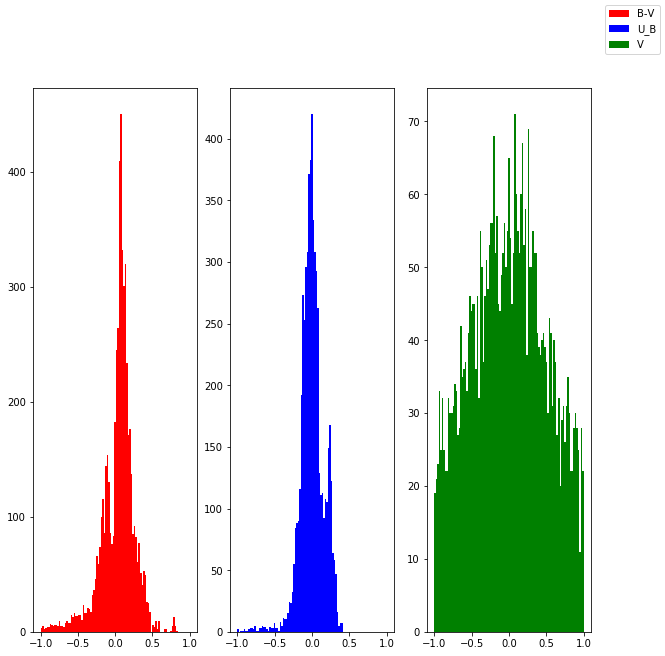

In [150]:
f, axes = plt.subplots(1, 3, figsize=(10,10))

RM_qlty = RM.pred - RM.y_test

labels = ['B-V', 'U_B','V']
color = ['red', 'blue', 'green']

for i, ax in enumerate(axes.ravel()):
    x = RM_qlty[:,i]
    ax.hist(x, bins = np.linspace(-1, 1, 100), label = labels[i], color = color[i])
 
f.legend();

In [154]:

#%%
data = pd.read_csv('NGC7793W_obs_wth_halpha')

#El modelo recibe un vector theta(Mass, Mup, log_age, log_met)
dist_modulu = 27.68


a = data.loc[data['bst_mass'] >=  1000]
targets = a.loc[(a['bst_age'] >=  1e6) & (a['bst_age'] <=  8e6)]

targets['log_age'] = np.log10(targets['bst_age'])
targets['log_mass'] = np.log10(targets['bst_mass' ])

obs_1 = targets.loc[targets['ID_1'] == 513].copy()
obs_2 = targets.loc[targets['ID_1'] == 1252].copy()
target_phot = obs_1[['F275W_1', 'F336W_1', 'F438W_1', 'F555W_1', 'F814W_1']].to_numpy()
target_phot = target_phot - 27.68

B_V_obs = target_phot[:,1] - target_phot[:,2]
U_B_obs = target_phot[:,0] - target_phot[:,1]
V_obs = target_phot[:,2]
target = np.array([B_V_obs, U_B_obs, V_obs])
target = np.reshape(target, (3,))


/home/roger/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/roger/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [157]:
obs_1

,col1,ID_1,x_1,y_1,RA_1,DEC_1,Cat_1,Iso_1,ID_2,x_2,...,F555W_err_2,rw_F657N,rw_F657N_err,F814W_2,F814W_err_2,rw_F814W,rw_F814W_err,Separation,log_age,log_mass
9,15,513,2048.217,4867.723,359.44214,-32.57895,3,True,513,2048.217,...,0.069,22.427,0.111,22.473,0.046,21.928,0.011,0.498571,6.778151,3.157759


Calentamiento..
Corriendo MCMC
Listo!
[2.06259324e+03 4.38560792e+06 4.10802846e-03]
   bst_mass    bst_age
9    1438.0  6000000.0


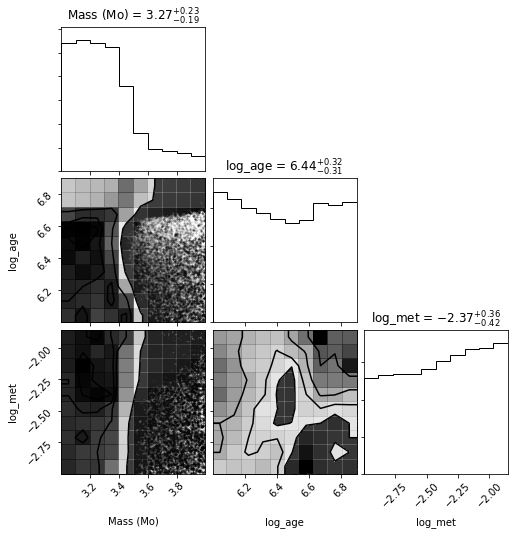

In [152]:
walkers = 600
niter = 1000
initial = sub[['log_mass', 'log_age', 'log_met']]
ndim = initial.shape[1]
p0 = [initial + 1e-2 * np.random.randn(ndim) for i in np.arange(walkers)]   
p01 = list(X_train_det.min(0) + ((X_train_det.max(0) - X_train_det.min(0)) * np.random.rand(walkers, ndim)))


RM.verbose = False
sampler, pos, porb, state = main(p01, walkers, niter, ndim, lnprob, vectorized = True)
#%%
samples = sampler.flatchain

print(10**(samples[np.argmax(sampler.flatlnprobability)]))
labels = ['Mass (Mo)', 'log_age', 'log_met']
samp = pd.DataFrame(samples, columns = labels)
print(obs_1[['log_mass', 'log_age']])
fig = corner.corner(samp,show_titles=True,labels=labels,plot_datapoints=True, bins = 10, smoth = 3)




In [ ]:

obs_2 = targets.loc[targets['ID_1'] == 1252].copy()
target_phot = obs_2[['F275W_1', 'F336W_1', 'F438W_1', 'F555W_1', 'F814W_1']].to_numpy()
target_phot = target_phot - 27.68

B_V_obs = target_phot[:,1] - target_phot[:,2]
U_B_obs = target_phot[:,0] - target_phot[:,1]
V_obs = target_phot[:,2]
target = np.array([B_V_obs, U_B_obs, V_obs])
target = np.reshape(target, (3,))


walkers = 5000
niter = 1000
initial = sub[['log_mass', 'log_age', 'log_met']]
ndim = initial.shape[1]
p0 = [initial + 1e-2 * np.random.randn(ndim) for i in np.arange(walkers)]   
p01 = list(X_train_det.min(0) + ((X_train_det.max(0) - X_train_det.min(0)) * np.random.rand(walkers, ndim)))


RM.verbose = False
sampler, pos, porb, state = main(p01, walkers, niter, ndim, lnprob, vectorized = True)
samples = sampler.flatchain
prop = 10**(samples[np.argmax(sampler.flatlnprobability)])
print("masa {:f}, edad {:f}, metalicidad {:f}".format(prop[0], prop[1], prop[2]))
labels = ['Mass (Mo)', 'log_age', 'log_met']
samp = pd.DataFrame(samples, columns = labels)
print(obs_1[['bst_mass', 'log_age']])
fig = corner.corner(samp,show_titles=True,labels=labels,plot_datapoints=True, bins = 30, smoth = 3)
